# Example on CIFAR10

In [2]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.models import Input, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
import matplotlib.pyplot as plt
import functools
import math

from keras_superconvergence import LRFinder, CyclicalLR, cycles
from keras_superconvergence.utils import PerBatchMetrics, PerEpochMetrics

# Suppress warnings
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10
IMAGE_SHAPE = (32, 32, 3)
NUM_TRAINING_DATA = X_train.shape[0]
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

def build_model(input_shape, num_classes):
  input = Input(input_shape)
  x = Conv2D(32, (3,3), padding='same')(input)
  x = Activation('elu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same')(x)
  x = Activation('elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = Activation('elu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same')(x)
  x = Activation('elu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.3)(x)

  x = Conv2D(128, (3,3), padding='same')(x)
  x = Activation('elu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), padding='same')(x)
  x = Activation('elu')(x)
  x = BatchNormalization()(x)
  
  # Adaptive Concat Pooling
  maxpool = GlobalMaxPooling2D()(x)
  avgpool = GlobalAveragePooling2D()(x)
  x = Concatenate()([maxpool, avgpool])
  
  x = Dropout(0.3)(x)
  x = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=input, outputs=x)
  
  return model

Using TensorFlow backend.


170500096/170498071 [==============================] - 10s 0us/step


In [0]:
def plot_metrics(batch_metrics, epoch_metrics):
  
  loss_at_random = -math.log2(1.0/NUM_CLASSES)
  
  plt.figure(figsize=(15, 7))
  plt.plot(batch_metrics.iteration, batch_metrics.logs['loss'])
  plt.plot(epoch_metrics.iteration, epoch_metrics.logs['val_loss'])
  plt.xlabel('Training Iterations')
  plt.ylabel('Loss')
  plt.title('Loss')
  plt.legend(['train', 'test'], loc='upper left')
  plt.ylim(0.0, loss_at_random)

  plt.figure(figsize=(15, 7))
  plt.plot(epoch_metrics.iteration, epoch_metrics.logs['val_acc'])
  plt.xlabel('Training Iterations')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy')

  plt.figure(figsize=(15, 5))
  plt.xlabel('Training Iterations')
  plt.ylabel('Learning Rate')
  plt.title("Learning Rate")
  plt.plot(batch_metrics.iteration, batch_metrics.lr)

# Standard Run

The standard way of training, with a monotonically decreasing learning rate.

In [0]:
batch_size = 64
num_epochs = 100

batch_metrics_std = PerBatchMetrics()
epoch_metrics_std = PerEpochMetrics()
plateau = ReduceLROnPlateau()

model = build_model(IMAGE_SHAPE, NUM_CLASSES)
model.compile(optimizer=Adam(lr=3e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(generator.flow(X_train, y_train, batch_size=batch_size), epochs=num_epochs, 
                    validation_data=(X_test, y_test), steps_per_epoch=NUM_TRAINING_DATA//batch_size,
                    callbacks=[plateau, batch_metrics_std, epoch_metrics_std], verbose=True)

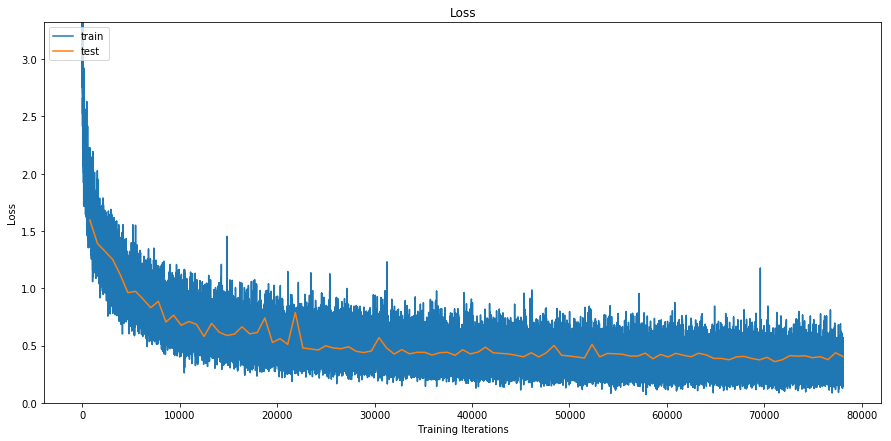

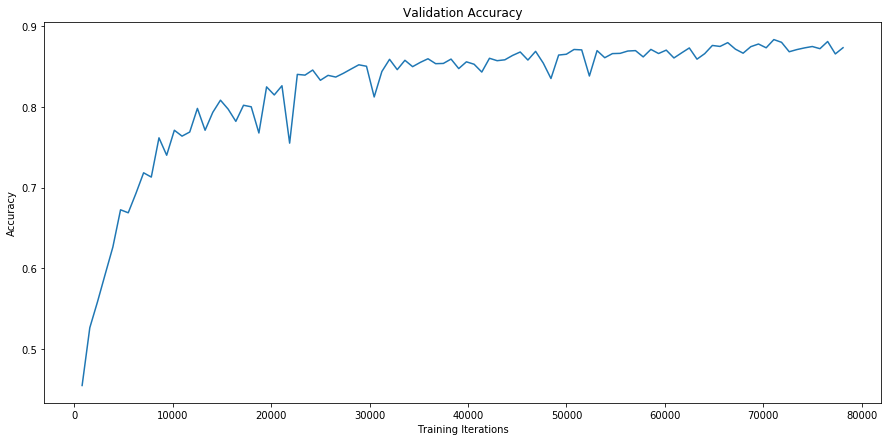

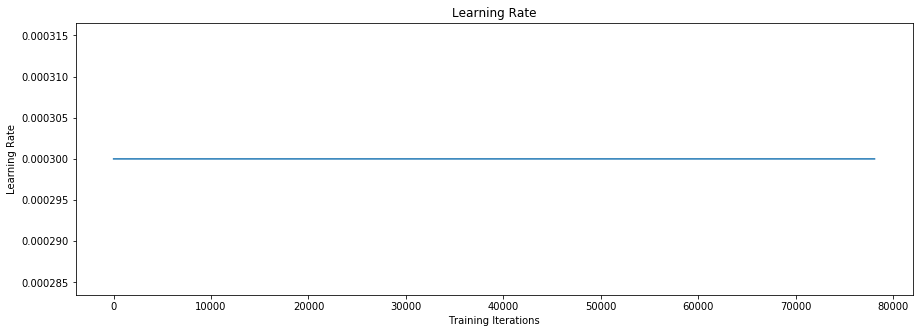

In [5]:
plot_metrics(batch_metrics_std, epoch_metrics_std)

# Cyclical Learning Rates

First we find `max_lr` using LRFinder. The 'sweet spot' should be one at the steepest decline of the loss, or one order of magnitude before the loss starts climbing too high.

Epoch 1/1
50000/50000 [==============================] - 9s 173us/step - loss: 4.2841 - acc: 0.1533


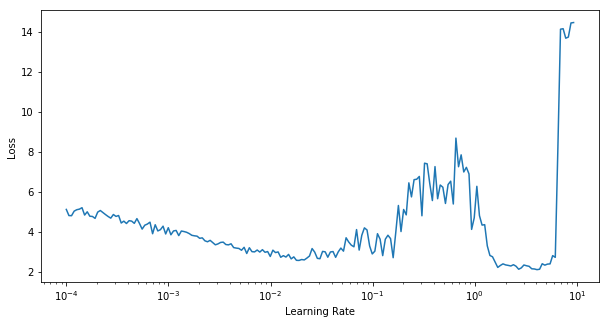

In [6]:
model = build_model(IMAGE_SHAPE, NUM_CLASSES)
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=1e-4, end_lr=1e1, batch_size=256, verbose=True)
plt.figure(figsize=(10,5))
lr_finder.plot_losses()

Instead of monotonically decreasing the learning rate, this method lets the learning rate cyclically vary between reasonable boundary values. Training with cyclical learning rates instead of fixed values achieves improved classification accuracy without a need to tune and often in fewer iterations. Here we use a slanted triangular policy.

In [0]:
max_lr = 1e0
batch_size = 256
num_epochs = 50
num_cycles = 4
cycle = functools.partial(cycles.triangular, slant=0.75)

batch_metrics_clr = PerBatchMetrics()
epoch_metrics_clr = PerEpochMetrics()
clr = CyclicalLR(cycle_fn=cycle, max_lr=max_lr, max_momentum=0.90, min_momentum=0.80, div_factor=25.0,
                 num_cycles=num_cycles, num_epochs=num_epochs, steps_per_epoch=math.ceil(NUM_TRAINING_DATA/batch_size))

model = build_model(IMAGE_SHAPE, NUM_CLASSES)
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(generator.flow(X_train, y_train, batch_size=batch_size), epochs=num_epochs, 
                    validation_data=(X_test, y_test), steps_per_epoch=NUM_TRAINING_DATA//batch_size,
                    callbacks=[clr, batch_metrics_clr, epoch_metrics_clr], verbose=True)

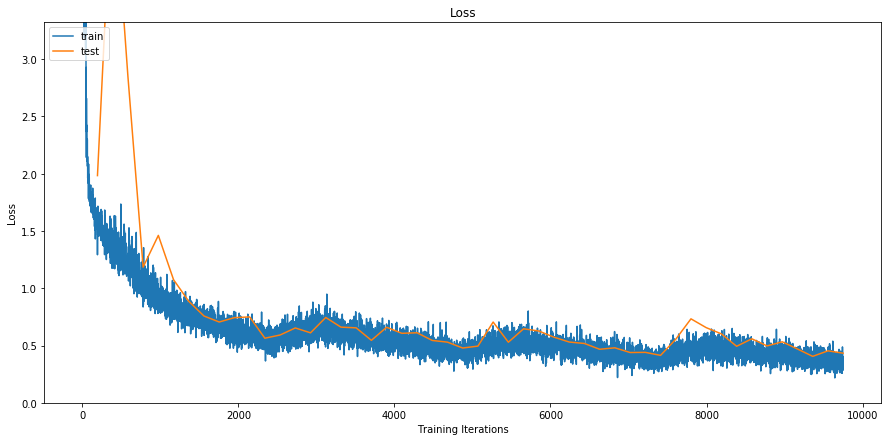

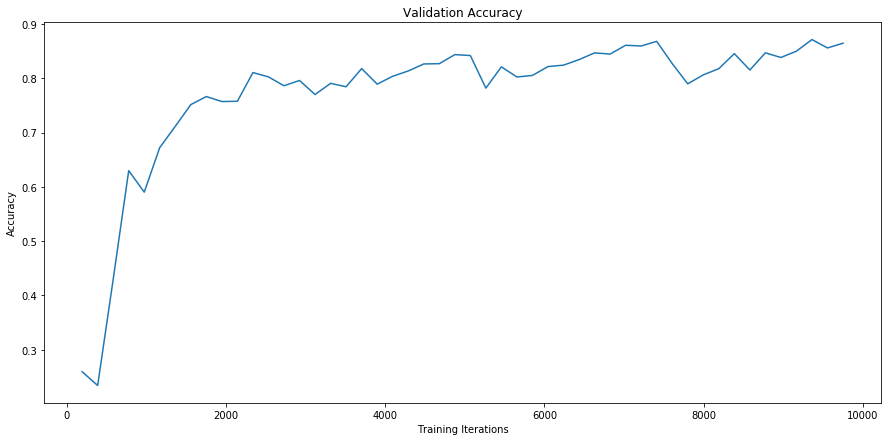

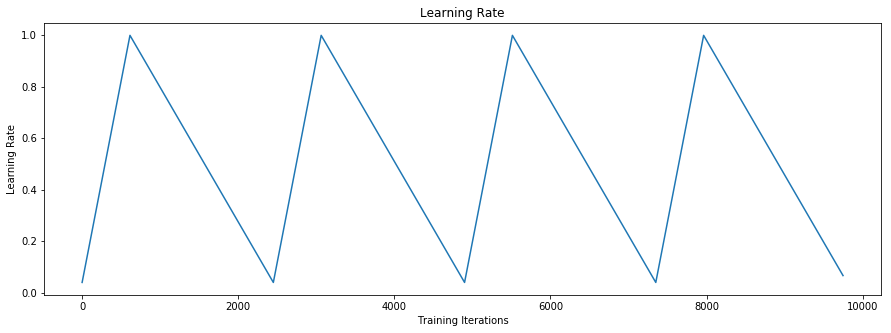

In [8]:
plot_metrics(batch_metrics_clr, epoch_metrics_clr)

# Super-convergence aka One Cycle Policy

Now instead of multiple cycles, we use only one cycle to achieve a phenomenon called 'super-convergence'. Here we use a slanted sine wave policy.

In [0]:
max_lr = 1e0
batch_size = 256
num_epochs = 50
num_cycles = 1
cycle = functools.partial(cycles.sine, slant=0.75)

batch_metrics_one_cycle = PerBatchMetrics()
epoch_metrics_one_cycle = PerEpochMetrics()
clr = CyclicalLR(cycle_fn=cycle, max_lr=max_lr, max_momentum=0.90, min_momentum=0.80, div_factor=25.0,
                 num_cycles=num_cycles, num_epochs=num_epochs, steps_per_epoch=math.ceil(NUM_TRAINING_DATA/batch_size))

model = build_model(IMAGE_SHAPE, NUM_CLASSES)
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(generator.flow(X_train, y_train, batch_size=batch_size), epochs=num_epochs, 
                    validation_data=(X_test, y_test), steps_per_epoch=NUM_TRAINING_DATA//batch_size,
                    callbacks=[clr, batch_metrics_one_cycle, epoch_metrics_one_cycle], verbose=True)

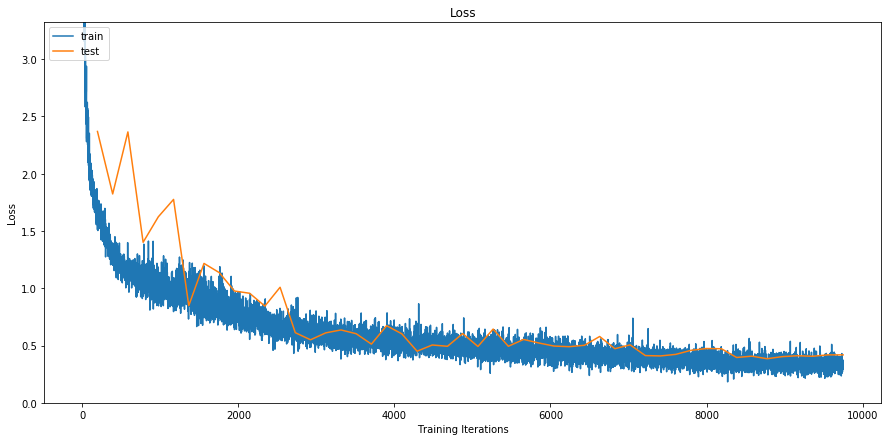

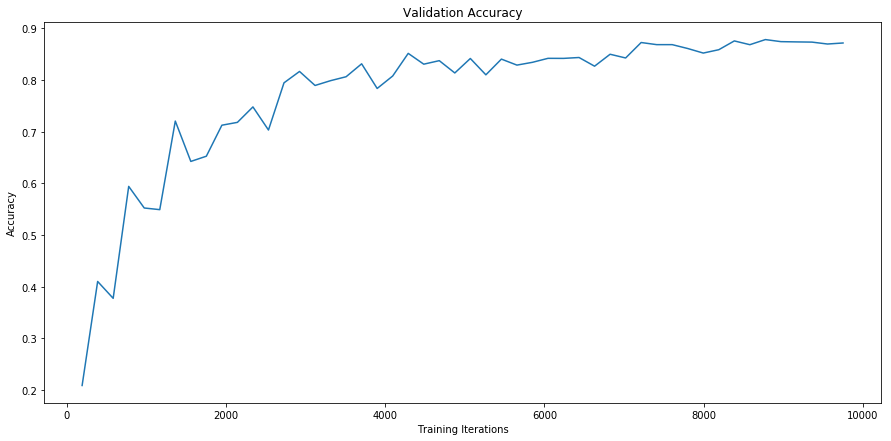

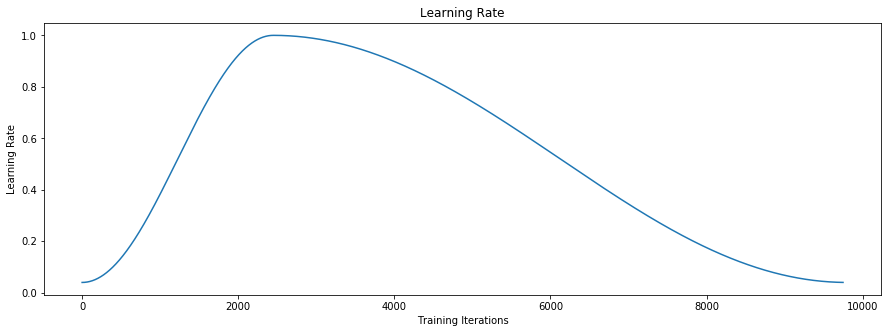

In [10]:
plot_metrics(batch_metrics_one_cycle, epoch_metrics_one_cycle)

# Comparison

In [0]:
def compare_metrics(batch_metrics_std, epoch_metrics_std,
                batch_metrics_clr, epoch_metrics_clr, 
                batch_metrics_one_cycle, epoch_metrics_one_cycle):
  
  plt.figure(figsize=(15, 7))
  plt.plot(epoch_metrics_std.iteration, epoch_metrics_std.logs['val_acc'])
  plt.plot(epoch_metrics_clr.iteration, epoch_metrics_clr.logs['val_acc'])
  plt.plot(epoch_metrics_one_cycle.iteration, epoch_metrics_one_cycle.logs['val_acc'])
  plt.xlabel('Training Iterations')
  plt.ylabel('Accuracy')
  plt.title('val_acc')
  plt.legend(['Standard', 'CLR', 'One Cycle'])

  plt.figure(figsize=(15, 5))
  plt.xlabel('Training Iterations')
  plt.ylabel('Learning Rate')
  plt.title("Standard Learning Rate")
  plt.plot(batch_metrics_std.lr)
  
  plt.figure(figsize=(15, 5))
  plt.xlabel('Training Iterations')
  plt.ylabel('Learning Rate')
  plt.title("CLR Learning Rate")
  plt.plot(batch_metrics_clr.lr)
  
  plt.figure(figsize=(15, 5))
  plt.xlabel('Training Iterations')
  plt.ylabel('Learning Rate')
  plt.title("One Cycle Learning Rate")
  plt.plot(batch_metrics_one_cycle.lr)

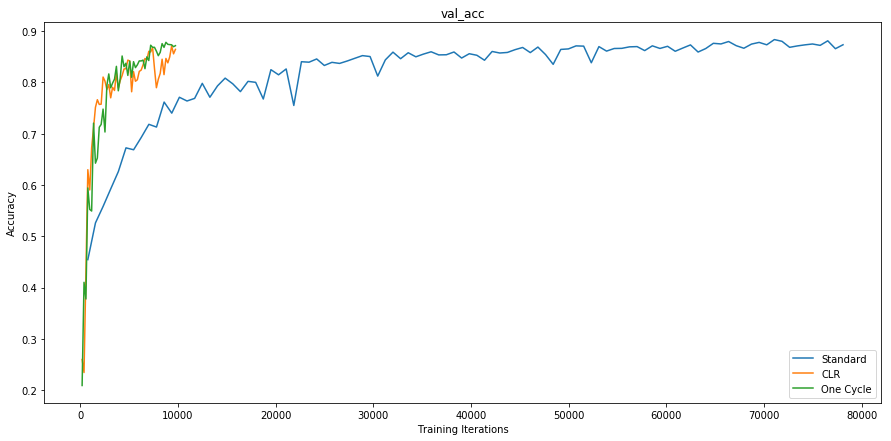

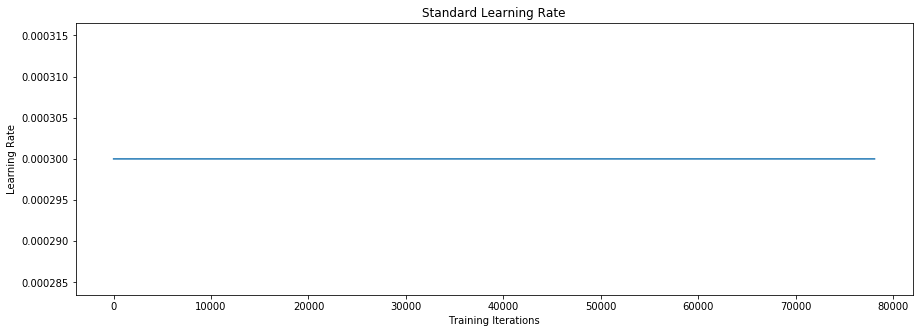

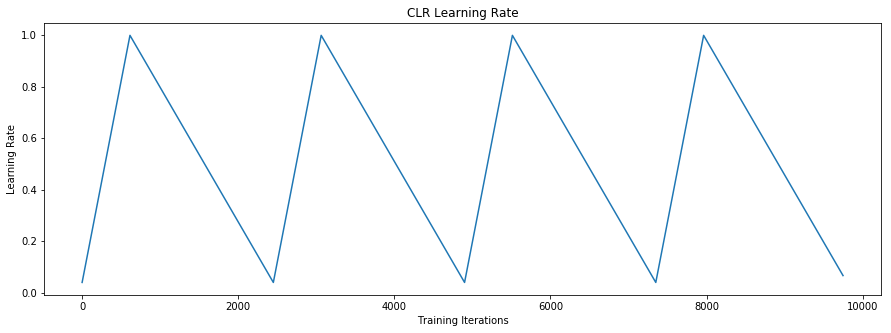

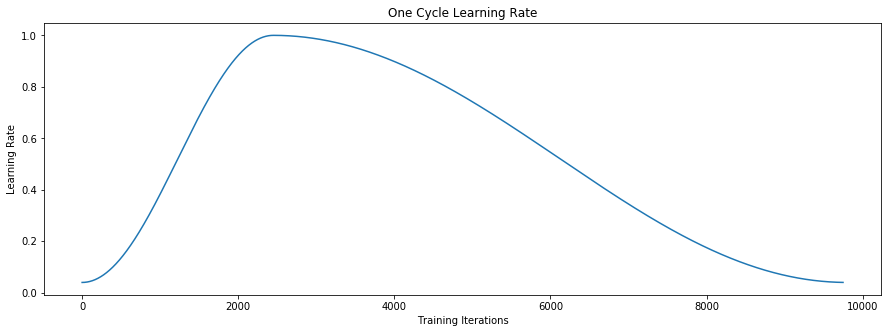

In [12]:
compare_metrics(batch_metrics_std, epoch_metrics_std,
                batch_metrics_clr, epoch_metrics_clr, 
                batch_metrics_one_cycle, epoch_metrics_one_cycle)